In [1]:
# imports
%load_ext autoreload
%autoreload 2

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

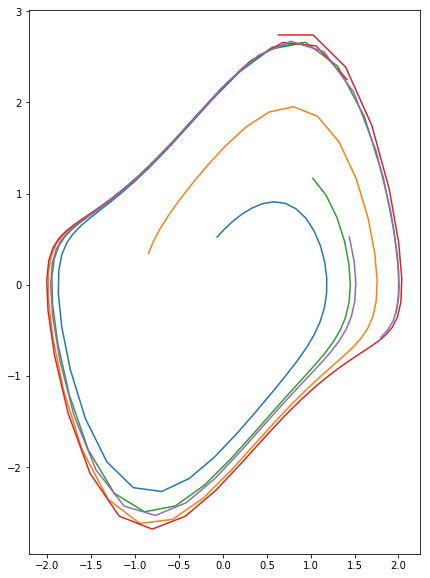

In [2]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], (1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint, odeint_adjoint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

x0 = torch.from_numpy(ss.norm.rvs(size=[5,2]))
t = torch.linspace(0., 7., 50)

with torch.no_grad():
    X = odeint_adjoint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1
    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')

In [3]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

npode = KernelRegression()
lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
optimizer = optim.Adam(npode.parameters(), lr=5e-3)


In [4]:
# optimization
def closure():
    optimizer.zero_grad()
    xode = odeint(npode, x0, t).permute([1,0,2])
    loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
    loss.backward()
    return loss
    
for itr in range(500):
    optimizer.zero_grad()
    xode = odeint_adjoint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_adjoint(npode, x0, t, method='rk4').permute([1,0,2])
            loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

Iter 0000 | Total Loss 0.282536
Iter 0001 | Total Loss 0.251940
Iter 0002 | Total Loss 0.222322
Iter 0003 | Total Loss 0.193834
Iter 0004 | Total Loss 0.166688
Iter 0005 | Total Loss 0.141134
Iter 0006 | Total Loss 0.117440
Iter 0007 | Total Loss 0.095892
Iter 0008 | Total Loss 0.076794
Iter 0009 | Total Loss 0.060454
Iter 0010 | Total Loss 0.047162
Iter 0011 | Total Loss 0.037143
Iter 0012 | Total Loss 0.030502
Iter 0013 | Total Loss 0.027157
Iter 0014 | Total Loss 0.026783
Iter 0015 | Total Loss 0.028783
Iter 0016 | Total Loss 0.032321
Iter 0017 | Total Loss 0.036425
Iter 0018 | Total Loss 0.040157
Iter 0019 | Total Loss 0.042783
Iter 0020 | Total Loss 0.043878
Iter 0021 | Total Loss 0.043353
Iter 0022 | Total Loss 0.041391
Iter 0023 | Total Loss 0.038361
Iter 0024 | Total Loss 0.034720
Iter 0025 | Total Loss 0.030925
Iter 0026 | Total Loss 0.027378
Iter 0027 | Total Loss 0.024379
Iter 0028 | Total Loss 0.022111
Iter 0029 | Total Loss 0.020634
Iter 0030 | Total Loss 0.019898
Iter 003

Iter 0257 | Total Loss 0.003593
Iter 0258 | Total Loss 0.003575
Iter 0259 | Total Loss 0.003557
Iter 0260 | Total Loss 0.003540
Iter 0261 | Total Loss 0.003522
Iter 0262 | Total Loss 0.003504
Iter 0263 | Total Loss 0.003486
Iter 0264 | Total Loss 0.003469
Iter 0265 | Total Loss 0.003451
Iter 0266 | Total Loss 0.003433
Iter 0267 | Total Loss 0.003416
Iter 0268 | Total Loss 0.003398
Iter 0269 | Total Loss 0.003381
Iter 0270 | Total Loss 0.003363
Iter 0271 | Total Loss 0.003346
Iter 0272 | Total Loss 0.003328
Iter 0273 | Total Loss 0.003311
Iter 0274 | Total Loss 0.003293
Iter 0275 | Total Loss 0.003276
Iter 0276 | Total Loss 0.003259
Iter 0277 | Total Loss 0.003242
Iter 0278 | Total Loss 0.003224
Iter 0279 | Total Loss 0.003207
Iter 0280 | Total Loss 0.003190
Iter 0281 | Total Loss 0.003173
Iter 0282 | Total Loss 0.003156
Iter 0283 | Total Loss 0.003139
Iter 0284 | Total Loss 0.003122
Iter 0285 | Total Loss 0.003105
Iter 0286 | Total Loss 0.003088
Iter 0287 | Total Loss 0.003072
Iter 028

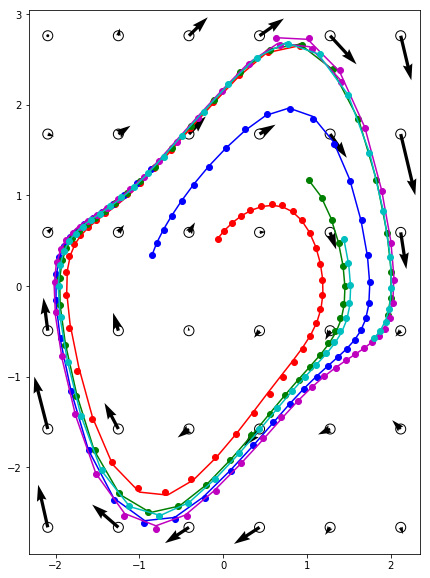

In [5]:
# plotting
xode = odeint_adjoint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])